<a href="https://colab.research.google.com/github/Raoufkioua/Mask-Detection-Application-/blob/master/breastCancerDetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
!unzip "/content/drive/My Drive/dataset.zip"


Archive:  /content/drive/My Drive/dataset.zip
replace dataset/Benign/SOB_B_A-14-22549AB-100-001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools

In [48]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG
benign_train = np.array(Dataset_loader('/content/dataset/benign',224))
malign_train = np.array(Dataset_loader('/content/dataset/malignant',224))
benign_test = np.array(Dataset_loader('/content/dataset/benign',224))
malign_test = np.array(Dataset_loader('/content/dataset/malignant',224))


100%|██████████| 821/821 [00:11<00:00, 72.49it/s]

100%|██████████| 3136/3136 [00:43<00:00, 72.79it/s]

100%|██████████| 821/821 [00:11<00:00, 71.68it/s]

100%|██████████| 3136/3136 [00:42<00:00, 73.05it/s]


In [49]:
import plotly.offline as py
import plotly.graph_objs as go
trace = go.Bar(x = (len(benign_train), len(malign_train)), y = ['benign', 'malignant'], orientation = 'h', opacity = 0.8, marker=dict(
        color=[ 'gold', 'lightskyblue'],
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  'Count of diagnosis variable')
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [0]:
print(len(benign_train))
print(len(malign_train))

821
3136


In [0]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

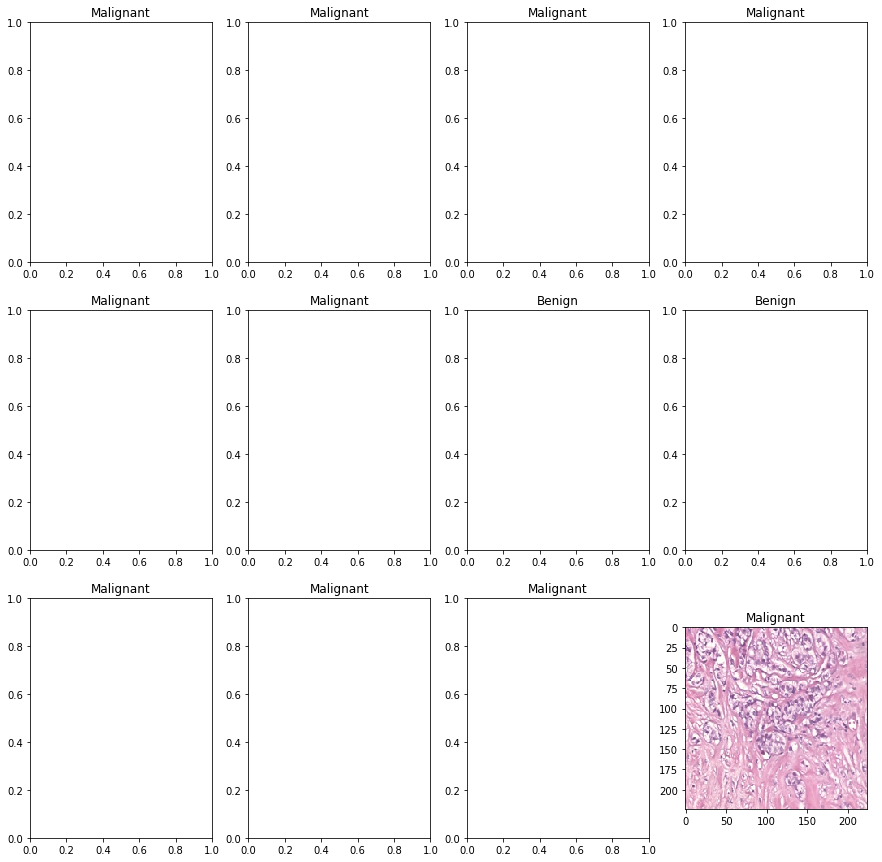

In [51]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
X_train, Y_train,
test_size=0.2,
random_state=11
)
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
       ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [52]:
print('x_train shape:',x_train.shape)
print('Number of images in x_train:', x_train.shape[0])
print('Number of images in x_test:', X_test.shape[0])
print('Number of images in x_val:', x_val.shape[0])


x_train shape: (3165, 224, 224, 3)
Number of images in x_train: 3165
Number of images in x_test: 3957
Number of images in x_val: 792


In [0]:
BATCH_SIZE = 16
train_generator = ImageDataGenerator(
  zoom_range=2, # set range for random zoom
  rotation_range = 90,
  horizontal_flip=True, # randomly flip images
  vertical_flip=True, # randomly flip images
)

In [95]:
def build_model(backbone, lr=1e-4):
      model = Sequential()
      model.add(backbone)
      model.add(layers.GlobalAveragePooling2D())
      model.add(layers.Dropout(0.5))
      model.add(layers.BatchNormalization())
      model.add(layers.Dense(2, activation='softmax'))
      model.compile(
      loss='binary_crossentropy',
      optimizer=Adam(lr=lr),
      metrics=['accuracy']
)
      return model
      

resnet = DenseNet201(
      weights='imagenet',
      include_top=False,
      input_shape=(224,224,3)
)
model = build_model(resnet ,lr = 1e-4)
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1920)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1920)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 3842      
Total params: 18,333,506
Trainable params: 18,100,610
Non-trainable params: 232,896
_________________________________________________________________


In [97]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
filepath="weights.best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)

history = model.fit_generator(
      train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
      steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
      epochs=20,
      validation_data=(x_val, y_val),
      callbacks=[learn_control, checkpoint]
)


Epoch 1/20
198/197 [==============================] - 176s 888ms/step - loss: 0.3803 - accuracy: 0.8531 - val_loss: 0.1181 - val_accuracy: 0.9722
Epoch 2/20


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning:

Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning:

Can save best model only with val_acc available, skipping.



198/197 [==============================] - 96s 483ms/step - loss: 0.2165 - accuracy: 0.9299 - val_loss: 0.1095 - val_accuracy: 0.9583
Epoch 3/20
198/197 [==============================] - 95s 481ms/step - loss: 0.1569 - accuracy: 0.9434 - val_loss: 0.2626 - val_accuracy: 0.9003
Epoch 4/20
198/197 [==============================] - 95s 482ms/step - loss: 0.1392 - accuracy: 0.9482 - val_loss: 0.0228 - val_accuracy: 0.9924
Epoch 5/20
198/197 [==============================] - 95s 481ms/step - loss: 0.1175 - accuracy: 0.9567 - val_loss: 0.0373 - val_accuracy: 0.9861
Epoch 6/20
198/197 [==============================] - 95s 481ms/step - loss: 0.1112 - accuracy: 0.9586 - val_loss: 0.3066 - val_accuracy: 0.8990
Epoch 7/20
198/197 [==============================] - 95s 480ms/step - loss: 0.0872 - accuracy: 0.9671 - val_loss: 0.0535 - val_accuracy: 0.9861
Epoch 8/20
198/197 [==============================] - 95s 481ms/step - loss: 0.0926 - accuracy: 0.9633 - val_loss: 0.0294 - val_accuracy: 0.9

In [0]:
model.save_weights('weights.best.hdf5')


In [0]:
model.metrics_names
model.load_weights('weights.best.hdf5')


In [78]:
!pip install tensorflowjs

     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 104.6MB 29kB/s 
     |████████████████████████████████| 92kB 14.7MB/s 
     |████████████████████████████████| 256kB 74.5MB/s 
     |████████████████████████████████| 921kB 77.3MB/s 
     |████████████████████████████████| 450kB 74.2MB/s 
     |████████████████████████████████| 3.9MB 70.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=cd1d5fda34cab086a00dbb3dce2946be5c3e727b223ec6fc895cf9ce73cbd215
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32851 sha256=2d6c2cf41bdb82abb6378f11f6c93c3ae5092110d673361a0d23a8d0dfeb2962
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built gast PyInquirer
ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, b

In [79]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, "model_js")

/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:122: H5pyDeprecationWarning:

The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.



In [101]:
# evaluate the model
score = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 99.65%


In [102]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(X_test, Y_test, batch_size=128)
print('test loss, test acc:', results)


# Evaluate on test data
3957/3957 [==============================] - 21s 5ms/step
test loss, test acc: [0.012470359154966313, 0.9964619874954224]


In [0]:
Y_val_pred = model.predict(x_val)


In [0]:
Y_pred = model.predict(X_test)

In [0]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False), steps = len(X_test)/BATCH_SIZE)
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

Y_pred_tta =np.mean(np.equal(np.argmax(y_val, axis=-1), np.argmax(pred, axis=-1)))


 90%|█████████ | 9/10 [05:51<00:38, 38.27s/it]

In [1]:
  from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

NameError: ignored

Train: 0.996, Test: 0.996


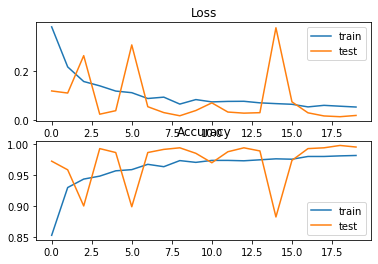

In [113]:
# evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=0)
_, test_acc = model.evaluate(X_test, Y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [117]:

# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)


# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(Y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

ValueError: ignored

In [124]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_test, axis=-1), np.argmax(Y_pred_tta, axis=-1)))



TypeError: ignored

In [122]:

from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

AxisError: ignored

In [0]:
pwd


'/content'